In [1]:
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
import uproot
import awkward
import numpy as np
import matplotlib.pyplot as plt
from FireHydrant.Tools.metfilter import MetFilters
from FireHydrant.Tools.trigger import Triggers
from FireHydrant.Tools.correction import get_pu_weights_function, get_ttbar_weight, get_nlo_weight_function

np.seterr(divide='ignore', invalid='ignore', over='ignore')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [34]:
import json
import os
from os.path import join

########## backgrounds ##########
# bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_nonempty_v2.json')))
bkgdatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/skimmedbkg_triggerOr.json'))) # skim
bkgscales_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/backgrounds_scale_v2.json')))

# flatten datasets
bkgdatasets = {}
for group in bkgdatasets_:
    for tag in bkgdatasets_[group]:
        bkgdatasets[tag] = bkgdatasets_[group][tag]

# flatten scales
bkgscales = {}
for group in bkgscales_:
    for tag in bkgscales_[group]:
        bkgscales[tag] = bkgscales_[group][tag]

lumi = 59.74*1e3
for k in bkgscales:
    bkgscales[k] *= lumi

# mapping
bkgmapping = {}
for k in bkgdatasets_: bkgmapping[k] = list(bkgdatasets_[k])
####################################

########## data ##########
# # datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/control_data2018_v2.json')))
# datadatasets_=json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/Data/Samples/skimmed_control_data2018_triggerOr.json')))
# datadatasets = datadatasets_
# datamapping = {'data': list('ABCD')}
####################################

########## combine together ##########
datasets = {}
datasets.update(bkgdatasets)
# datasets.update(datadatasets)

mapping = {}
mapping.update(bkgmapping)
# mapping.update(datamapping)
####################################

########## signal ##########
dataset4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_v2-1.json')))
dataset2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_v2-1.json')))
scale4mu_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_4mu_scale.json')))
scale2mu2e_ = json.load(open(join(os.getenv('FH_BASE'), 'Notebooks/MC/Samples/signal_2mu2e_scale.json')))
sigmc_scales={}
for k in scale4mu_:
    sigmc_scales[f'4mu/{k}'] = lumi/1e3 * scale4mu_[k] # xsec is /fb
for k in scale2mu2e_:
    sigmc_scales[f'2mu2e/{k}'] = lumi/1e3 * scale2mu2e_[k]
sigmc_datasets = {}
for k in dataset4mu_:
    sigmc_datasets[f'4mu/{k}'] = dataset4mu_[k]
for k in dataset2mu2e_:
    sigmc_datasets[f'2mu2e/{k}'] = dataset2mu2e_[k]

In [35]:
# common plotting options
fill_opts = {
    'edgecolor': (0,0,0,0.3),
    'alpha': 0.8
}
line_opts = {
    
}
error_opts = {
    'label':'Stat. Unc.',
    'hatch':'xxx',
    'facecolor':'none',
    'edgecolor':(0,0,0,.5),
    'linewidth': 0
}
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
    'emarker': '_'
}

In [36]:
# Triggers = Triggers.extend(["HLT_Mu38NoFiltersNoVtxDisplaced_Photon38_CaloIdL", "HLT_Mu43NoFiltersNoVtx_Photon43_CaloIdL",])
# Triggers = Triggers[:-2]
Triggers

['HLT_DoubleL2Mu23NoVtx_2Cha',
 'HLT_DoubleL2Mu23NoVtx_2Cha_NoL2Matched',
 'HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed',
 'HLT_DoubleL2Mu23NoVtx_2Cha_CosmicSeed_NoL2Matched',
 'HLT_DoubleL2Mu25NoVtx_2Cha_Eta2p4',
 'HLT_DoubleL2Mu25NoVtx_2Cha_CosmicSeed_Eta2p4']

In [47]:
 class LeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'backgrounds')
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 30, 0, np.pi)
        invm1_axis = hist.Bin('invm', 'mass[GeV]', 50, 0, 200)
        invm2_axis = hist.Bin('invm', 'mass[GeV]', 50, 0, 2000)
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            "ljpair-dphi": hist.Hist("#counts", dataset_axis, dphi_axis, channel_axis),
            "ljpair-invm1": hist.Hist("#counts", dataset_axis, invm1_axis, channel_axis),
            "ljpair-invm2": hist.Hist("#counts", dataset_axis, invm2_axis, channel_axis),
            'eventcnt': hist.Hist("Counts", dataset_axis, count_axis, channel_axis),
            'ljcnt': hist.Hist("Counts", dataset_axis, count_axis, label_axis, channel_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfiso=df['pfjet_pfIsolation05'], # pfiso06
            ncands=df['pfjet_pfcands_n']
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets.add_attributes(isoeg=(leptonjets.ismutype | (leptonjets.iseltype&((leptonjets.pfiso<0.1) | (leptonjets.ncands>=2)))))
        leptonjets = leptonjets[leptonjets.isneutral&leptonjets.isoeg]
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        ## region def ##
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        isSR = ~isControl
        ###########
        
        leptonjets_ = dileptonjets
#         leptonjets_ = dileptonjets[isControl]
        if leptonjets_.size==0: return output
#         wgt = wgt[isControl]
#         lj0 = lj0[isControl]
#         lj1 = lj1[isControl]
#         channel_ = channel_[isControl]
            
        output['eventcnt'].fill(dataset=dataset, cnt=np.ones_like(wgt), weight=wgt, channel=channel_)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
        output['ljcnt'].fill(dataset=dataset, cnt=np.ones_like(ljwgt), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        
        output['ljpair-dphi'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt, channel=channel_)
        output['ljpair-invm1'].fill(dataset=dataset, invm=(lj0.p4+lj1.p4).mass.flatten(), weight=wgt, channel=channel_)
        output['ljpair-invm2'].fill(dataset=dataset, invm=(lj0.p4+lj1.p4).mass.flatten(), weight=wgt, channel=channel_)
        
        return output
    
    def postprocess(self, accumulator):
        origidentity = list(accumulator)        
        for k in origidentity:
            accumulator[k].scale(bkgscales, axis='dataset')
            accumulator[k+'_cat'] = accumulator[k].group("dataset",
                                                         hist.Cat("cat", "datasets"),
                                                         mapping)
        return accumulator

In [48]:
output = processor.run_uproot_job(datasets,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=LeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 10/10 [00:02<00:00,  4.98items/s]


In [39]:
def makeplot(varname, title, overflow='none', logy=True, ylim=None):
    fig, axes=plt.subplots(1,2,figsize=(16,6))
    hist.plot1d(output[varname+'_cat'].integrate('channel', slice(1,2)), overlay='cat', ax=axes[0],
               clear=False, stack=True, overflow=overflow,
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output[varname+'_cat'].integrate('channel', slice(2,3)), overlay='cat', ax=axes[1],
               clear=False, stack=True, overflow=overflow,
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    for ax in axes:
        ax.autoscale(axis='x', tight=True)
        if logy:
            ax.set_yscale('symlog')
            ax.autoscale(axis='y', tight=True)
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        leg=ax.legend()
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    axes[0].set_title(f'[2mu2e] leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[4mu] leptonjets {title}', x=0.0, ha="left")

#######################
from collections import defaultdict
import pandas as pd

def printYield(channel):
    result = defaultdict(dict)
    if channel=='2mu2e':
        histCR = output['ljpair-dphi_cat'].integrate('channel', slice(1,2)).integrate('dphi', slice(0, np.pi/2))
        histSR = output['ljpair-dphi_cat'].integrate('channel', slice(1,2)).integrate('dphi', slice(np.pi/2, np.pi))
    if channel=='4mu':
        histCR = output['ljpair-dphi_cat'].integrate('channel', slice(2,3)).integrate('dphi', slice(0, np.pi/2))
        histSR = output['ljpair-dphi_cat'].integrate('channel', slice(2,3)).integrate('dphi', slice(np.pi/2, np.pi))
    for k, v in histCR.values().items():
        result['CR'][k[0]] = round(v, 2)
    for k, v in histSR.values().items():
        result['SR'][k[0]] = round(v, 2)
    
    return pd.DataFrame(result)

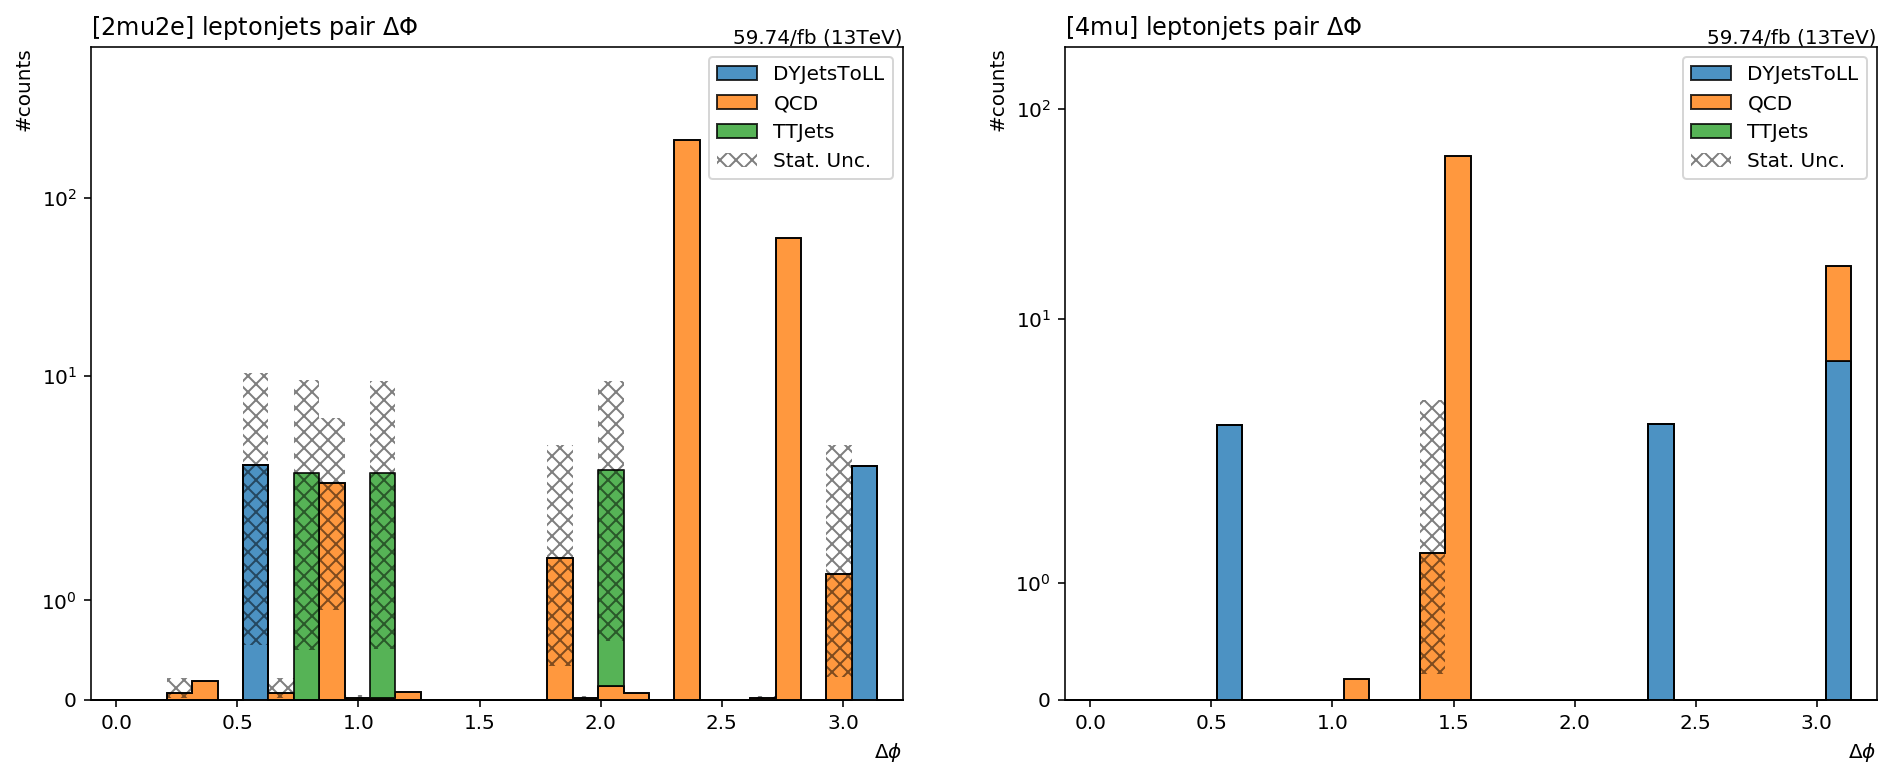

In [49]:
# varname='ljpair-dphi'
# overflow='all'
# title='pair $\Delta\Phi$'
# logy=True
# ylim=None
makeplot('ljpair-dphi', 'pair $\Delta\Phi$', overflow='all', logy=True, ylim=None)

In [50]:
print('== 2mu2e ==')
print(printYield('2mu2e'))
print('____________________________')
print('== 4mu ==')
print(printYield('4mu'))

== 2mu2e ==
              CR      SR
DYJetsToLL  3.17    3.14
QCD         2.97  272.62
TTJets      5.74    2.87
____________________________
== 4mu ==
               CR     SR
DYJetsToLL   3.14   9.52
QCD         61.10  11.59
TTJets       0.00   0.00


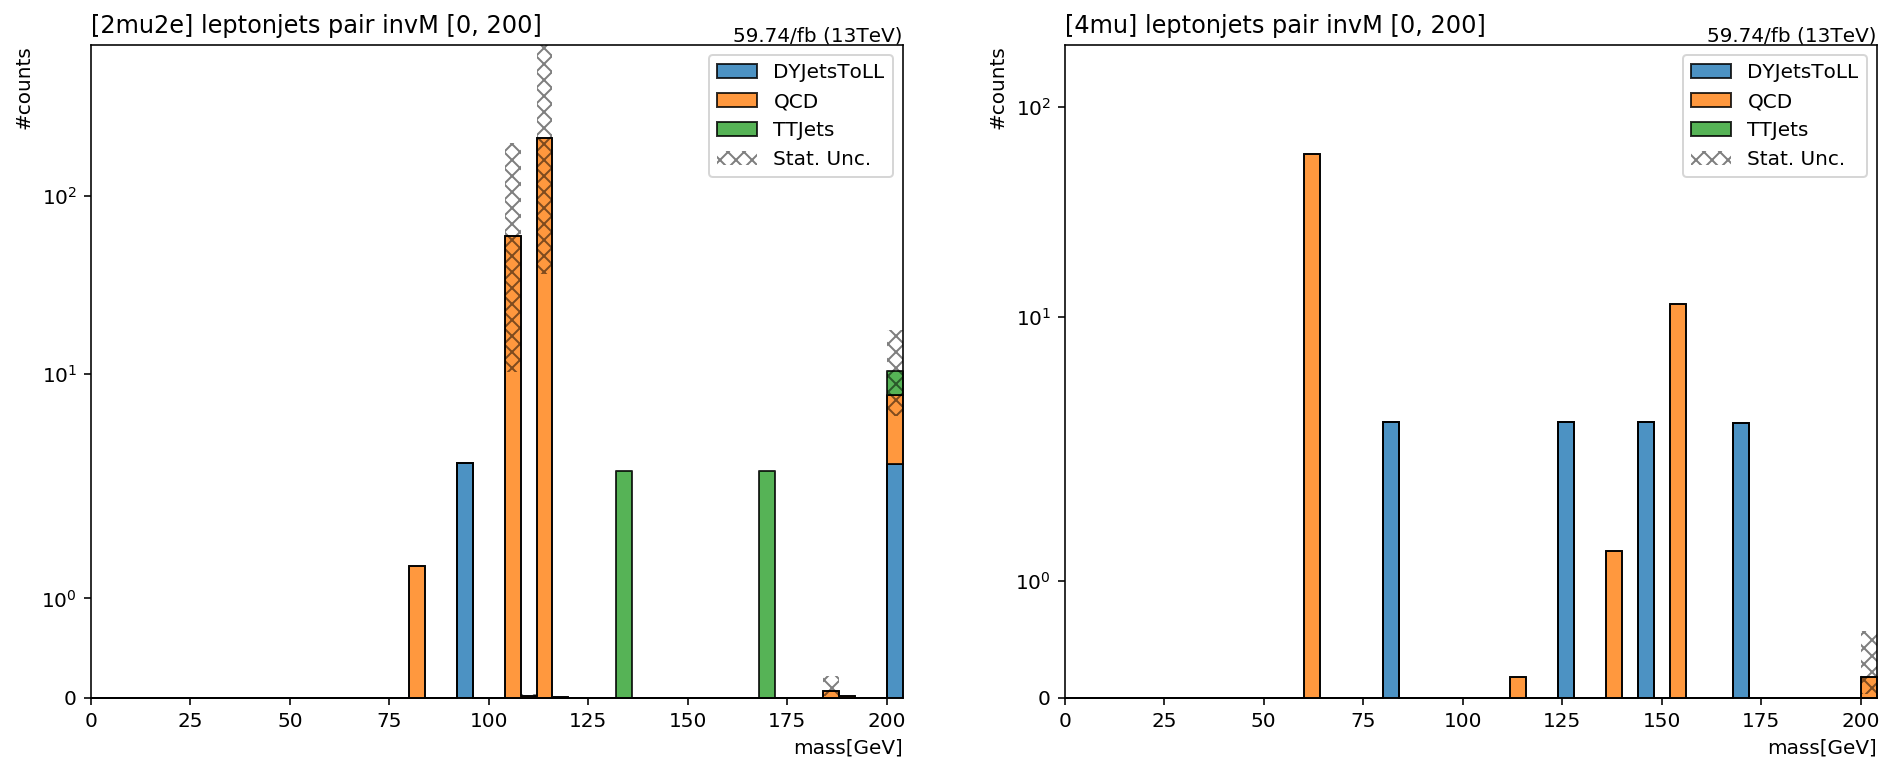

In [10]:
makeplot('ljpair-invm1', 'pair invM [0, 200]', overflow='over', logy=True, ylim=None)

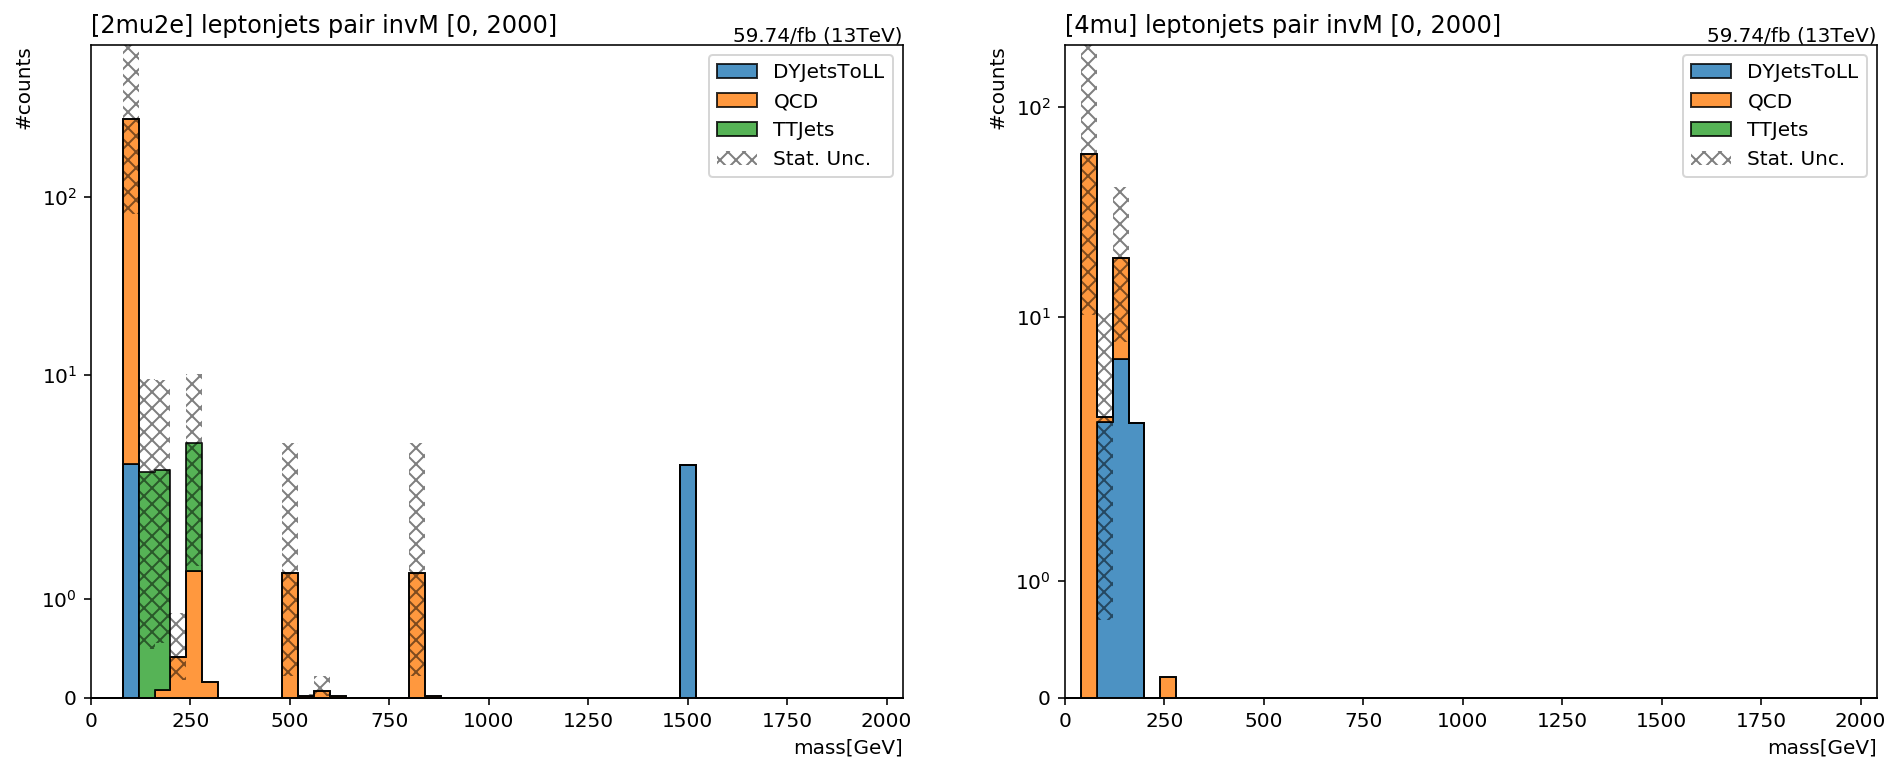

In [11]:
makeplot('ljpair-invm2', 'pair invM [0, 2000]', overflow='over', logy=True, ylim=None)

In [42]:
class SigLeptonJetProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat('dataset', 'signal')
        dphi_axis = hist.Bin('dphi', '$\Delta\phi$', 30, 0, np.pi)
        invm1_axis = hist.Bin('invm', 'mass[GeV]', 50, 0, 200)
        invm2_axis = hist.Bin('invm', 'mass[GeV]', 50, 0, 2000)
        label_axis = hist.Bin('label', 'leptonjet type', 4, 0, 4)
        channel_axis = hist.Bin('channel', 'channel', 3, 0, 3)
        count_axis = hist.Bin('cnt', 'event count', 1, 1, 2)
        
        self._accumulator = processor.dict_accumulator({
            "ljpair-dphi": hist.Hist("#counts", dataset_axis, dphi_axis, channel_axis),
            "ljpair-invm1": hist.Hist("#counts", dataset_axis, invm1_axis, channel_axis),
            "ljpair-invm2": hist.Hist("#counts", dataset_axis, invm2_axis, channel_axis),
            'eventcnt': hist.Hist("Counts", dataset_axis, count_axis, channel_axis),
            'ljcnt': hist.Hist("Counts", dataset_axis, count_axis, label_axis, channel_axis),
        })
        self.pucorrs = get_pu_weights_function()
        self.nlo_w = get_nlo_weight_function('w')
        self.nlo_z = get_nlo_weight_function('z')
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, df):
        output = self.accumulator.identity()
        if df.size==0: return output
        
        dataset = df['dataset']

        ## construct weights ##
        wgts = processor.Weights(df.size)
        if len(dataset)!=1:
            wgts.add('genw', df['weight'])
        
        triggermask = np.logical_or.reduce([df[t] for t in Triggers])
        wgts.add('trigger', triggermask)
        cosmicpairmask = df['cosmicveto_result']
        wgts.add('cosmicveto', cosmicpairmask)
        
        # ...bla bla, other weights goes here
        
        weight = wgts.weight()
        ########################
        
        leptonjets = JaggedCandidateArray.candidatesfromcounts(
            df['pfjet_p4'],
            px=df['pfjet_p4.fCoordinates.fX'],
            py=df['pfjet_p4.fCoordinates.fY'],
            pz=df['pfjet_p4.fCoordinates.fZ'],
            energy=df['pfjet_p4.fCoordinates.fT'],
            pfiso=df['pfjet_pfIsolation06'], # pfiso06
            ncands=df['pfjet_pfcands_n']
        )
        ljdautype = awkward.fromiter(df['pfjet_pfcand_type'])
        npfmu = (ljdautype==3).sum()
        ndsa = (ljdautype==8).sum()
        isegammajet = (npfmu==0)&(ndsa==0)
        ispfmujet = (npfmu>=2)&(ndsa==0)
        isdsajet = ndsa>0
        label = isegammajet.astype(int)*1+ispfmujet.astype(int)*2+isdsajet.astype(int)*3
        leptonjets.add_attributes(label=label)
        nmu = ((ljdautype==3)|(ljdautype==8)).sum()
        leptonjets.add_attributes(ismutype=(nmu>=2), iseltype=(nmu==0))
        ljdaucharge = awkward.fromiter(df['pfjet_pfcand_charge']).sum()
        leptonjets.add_attributes(qsum=ljdaucharge)
        leptonjets.add_attributes(isneutral=(leptonjets.iseltype | (leptonjets.ismutype&(leptonjets.qsum==0))))
        leptonjets.add_attributes(isoeg=(leptonjets.ismutype | (leptonjets.iseltype&((leptonjets.pfiso<0.1) | (leptonjets.ncands>=2)))))
        leptonjets = leptonjets[leptonjets.isneutral&leptonjets.isoeg]
                
        twoleptonjets = leptonjets.counts>=2
        dileptonjets = leptonjets[twoleptonjets]
        wgt = weight[twoleptonjets]
        
        if dileptonjets.size==0: return output
        lj0 = dileptonjets[dileptonjets.pt.argmax()]
        lj1 = dileptonjets[dileptonjets.pt.argsort()[:, 1:2]]
        
        ## channel def ##
        singleMuljEvents = dileptonjets.ismutype.sum()==1
        muljInLeading2Events = (lj0.ismutype | lj1.ismutype).flatten()
        channel_2mu2e = (singleMuljEvents&muljInLeading2Events).astype(int)*1
        
        doubleMuljEvents = dileptonjets.ismutype.sum()==2
        muljIsLeading2Events = (lj0.ismutype & lj1.ismutype).flatten()
        channel_4mu = (doubleMuljEvents&muljIsLeading2Events).astype(int)*2
        
        channel_ = channel_2mu2e + channel_4mu
        ###########
        
        ## region def ##
        isControl = (np.abs(lj0.p4.delta_phi(lj1.p4))<np.pi/2).flatten()
        isSR = ~isControl
        ###########
        
        leptonjets_ = dileptonjets
#         leptonjets_ = dileptonjets[isControl]
        if leptonjets_.size==0: return output
#         wgt = wgt[isControl]
#         lj0 = lj0[isControl]
#         lj1 = lj1[isControl]
#         channel_ = channel_[isControl]
            
        output['eventcnt'].fill(dataset=dataset, cnt=np.ones_like(wgt), weight=wgt, channel=channel_)
        ljwgt = (leptonjets_.pt.ones_like()*wgt).flatten()
        ljchannel = (leptonjets_.pt.ones_like()*channel_).flatten()
        output['ljcnt'].fill(dataset=dataset, cnt=np.ones_like(ljwgt), label=leptonjets_.label.flatten(), weight=ljwgt, channel=ljchannel)
        
        output['ljpair-dphi'].fill(dataset=dataset, dphi=np.abs(lj0.p4.delta_phi(lj1.p4)).flatten(), weight=wgt, channel=channel_)
        output['ljpair-invm1'].fill(dataset=dataset, invm=(lj0.p4+lj1.p4).mass.flatten(), weight=wgt, channel=channel_)
        output['ljpair-invm2'].fill(dataset=dataset, invm=(lj0.p4+lj1.p4).mass.flatten(), weight=wgt, channel=channel_)
        
        return output
    
    def postprocess(self, accumulator):
        for k in accumulator:
            accumulator[k].scale(sigmc_scales, axis='dataset')
        return accumulator

In [43]:
_selected4mu = {k: v for k, v in sigmc_datasets.items() if k.startswith('4mu')}
sigoutput={}
sigoutput['4mu'] = processor.run_uproot_job(_selected4mu,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=SigLeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )
_selected2mu2e = {}
for k in _selected4mu:
    k_ = k.replace('4mu', '2mu2e')
    _selected2mu2e[k_] = sigmc_datasets[k_]
sigoutput['2mu2e'] = processor.run_uproot_job(_selected2mu2e,
                                  treename='ffNtuplizer/ffNtuple',
                                  processor_instance=SigLeptonJetProcessor(),
                                  executor=processor.futures_executor,
                                  executor_args=dict(workers=12, flatten=True),
                                  chunksize=500000,
                                 )

Processing: 100%|██████████| 100/100 [00:12<00:00,  8.28items/s]


In [44]:
def makeplotsignal(varname, title, overflow='none', logy=True):
    fig,axes = plt.subplots(1,2,figsize=(16,6))
    hist.plot1d(sigoutput['2mu2e'][varname].integrate('channel', slice(1,2)), overlay='dataset', ax=axes[0])
    hist.plot1d(sigoutput['4mu'][varname].integrate('channel', slice(2,3)), overlay='dataset', ax=axes[1])
    axes[0].set_title(f'[2mu2e] leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[4mu] leptonjets {title}', x=0.0, ha="left")
    for ax in axes.flat:
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)
        if logy:
            ax.set_yscale('symlog')
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right");

def printMCYield(channel):
    result = defaultdict(dict)
    if channel=='2mu2e':
        histCR = output['ljpair-dphi_cat'].integrate('channel', slice(1,2)).integrate('dphi', slice(0, np.pi/2))
        histSR = output['ljpair-dphi_cat'].integrate('channel', slice(1,2)).integrate('dphi', slice(np.pi/2, np.pi))
        histSigCR = sigoutput['2mu2e']['ljpair-dphi'].integrate('channel', slice(1,2)).integrate('dphi', slice(0, np.pi/2))
        histSigSR = sigoutput['2mu2e']['ljpair-dphi'].integrate('channel', slice(1,2)).integrate('dphi', slice(np.pi/2, np.pi))
    if channel=='4mu':
        histCR = output['ljpair-dphi_cat'].integrate('channel', slice(2,3)).integrate('dphi', slice(0, np.pi/2))
        histSR = output['ljpair-dphi_cat'].integrate('channel', slice(2,3)).integrate('dphi', slice(np.pi/2, np.pi))
        histSigCR = sigoutput['4mu']['ljpair-dphi'].integrate('channel', slice(2,3)).integrate('dphi', slice(0, np.pi/2))
        histSigSR = sigoutput['4mu']['ljpair-dphi'].integrate('channel', slice(2,3)).integrate('dphi', slice(np.pi/2, np.pi))
    for k, v in histCR.values().items():
        result['CR'][k[0]] = round(v, 3)
    for k, v in histSR.values().items():
        result['SR'][k[0]] = round(v, 3)
        
    for k, v in histSigCR.values().items():
        result['CR'][k[0]] = round(v, 3)
    for k, v in histSigSR.values().items():
        result['SR'][k[0]] = round(v, 3)
    
    return pd.DataFrame(result)

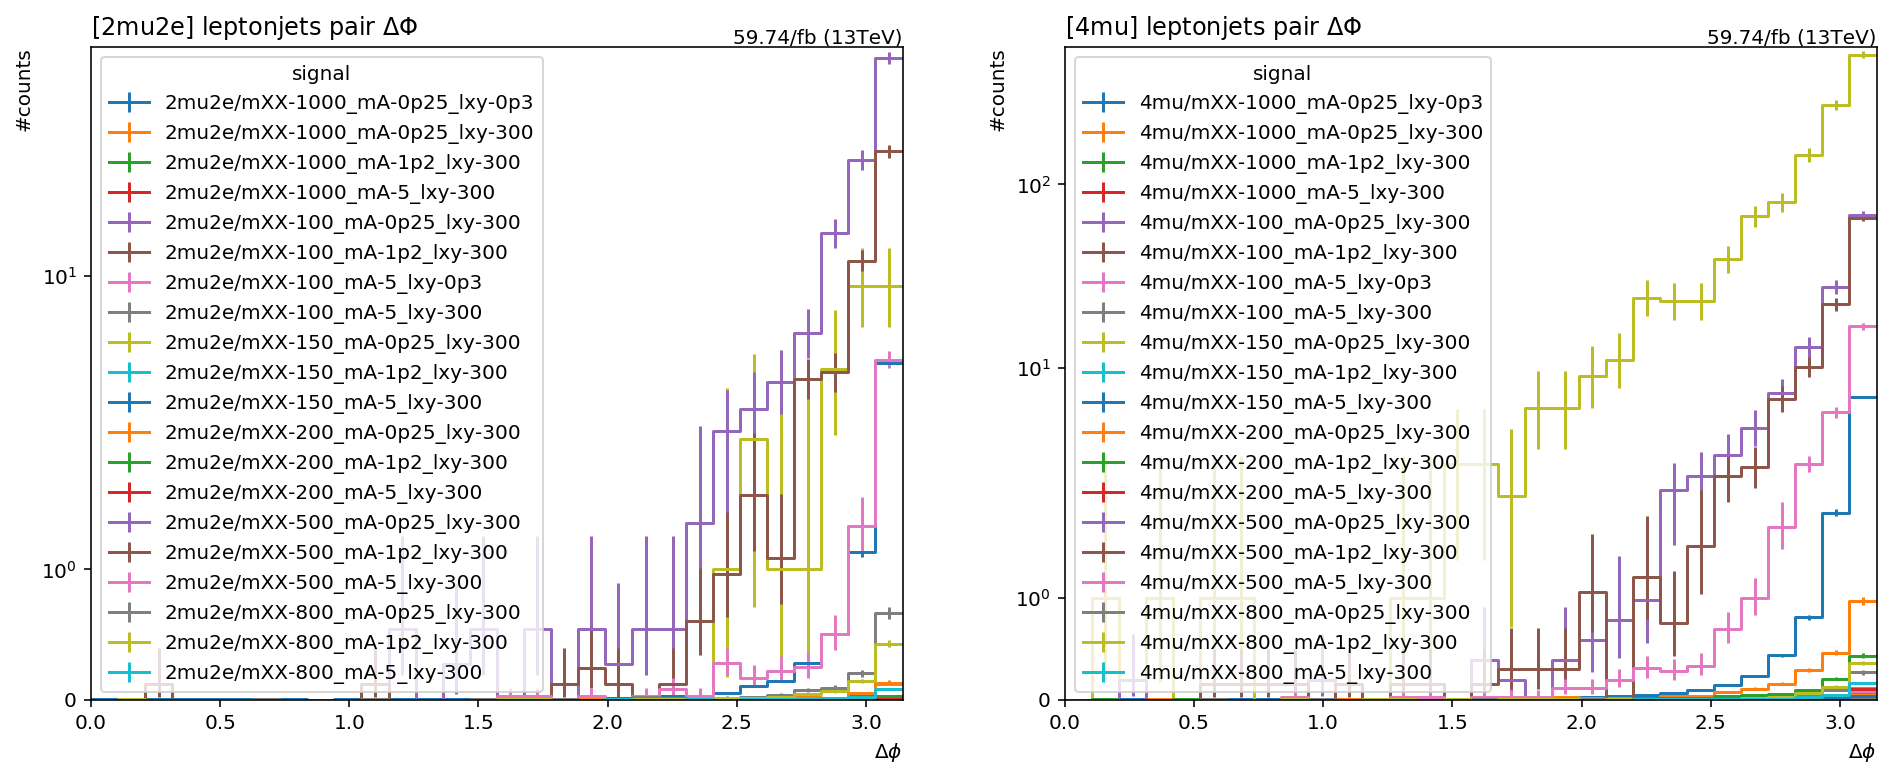

In [24]:
makeplotsignal('ljpair-dphi', 'pair $\Delta\Phi$', overflow='all', logy=True)

In [45]:
printMCYield('2mu2e')

,CR,SR
2mu2e/mXX-1000_mA-0p25_lxy-0p3,0.018,5.579
2mu2e/mXX-1000_mA-0p25_lxy-300,0.000,0.172
2mu2e/mXX-1000_mA-1p2_lxy-300,0.000,0.170
2mu2e/mXX-1000_mA-5_lxy-300,0.000,0.034
2mu2e/mXX-100_mA-0p25_lxy-300,0.000,0.001
2mu2e/mXX-100_mA-1p2_lxy-300,0.000,0.000
2mu2e/mXX-100_mA-5_lxy-0p3,0.000,0.014
2mu2e/mXX-100_mA-5_lxy-300,0.000,0.000
2mu2e/mXX-150_mA-0p25_lxy-300,0.000,7.000
2mu2e/mXX-150_mA-1p2_lxy-300,0.000,0.003


In [46]:
printMCYield('4mu')

,CR,SR
4mu/mXX-1000_mA-0p25_lxy-0p3,0.035,10.722
4mu/mXX-1000_mA-0p25_lxy-300,0.001,0.080
4mu/mXX-1000_mA-1p2_lxy-300,0.001,0.149
4mu/mXX-1000_mA-5_lxy-300,0.000,0.060
4mu/mXX-100_mA-0p25_lxy-300,0.001,0.188
4mu/mXX-100_mA-1p2_lxy-300,0.000,0.050
4mu/mXX-100_mA-5_lxy-0p3,0.002,0.216
4mu/mXX-100_mA-5_lxy-300,0.000,0.011
4mu/mXX-150_mA-0p25_lxy-300,9.000,1216.000
4mu/mXX-150_mA-1p2_lxy-300,0.003,0.248


/uscms/home/wsi/nobackup/miniconda3/envs/FireHydrant/lib/python3.7/site-packages/coffea/hist/plot.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


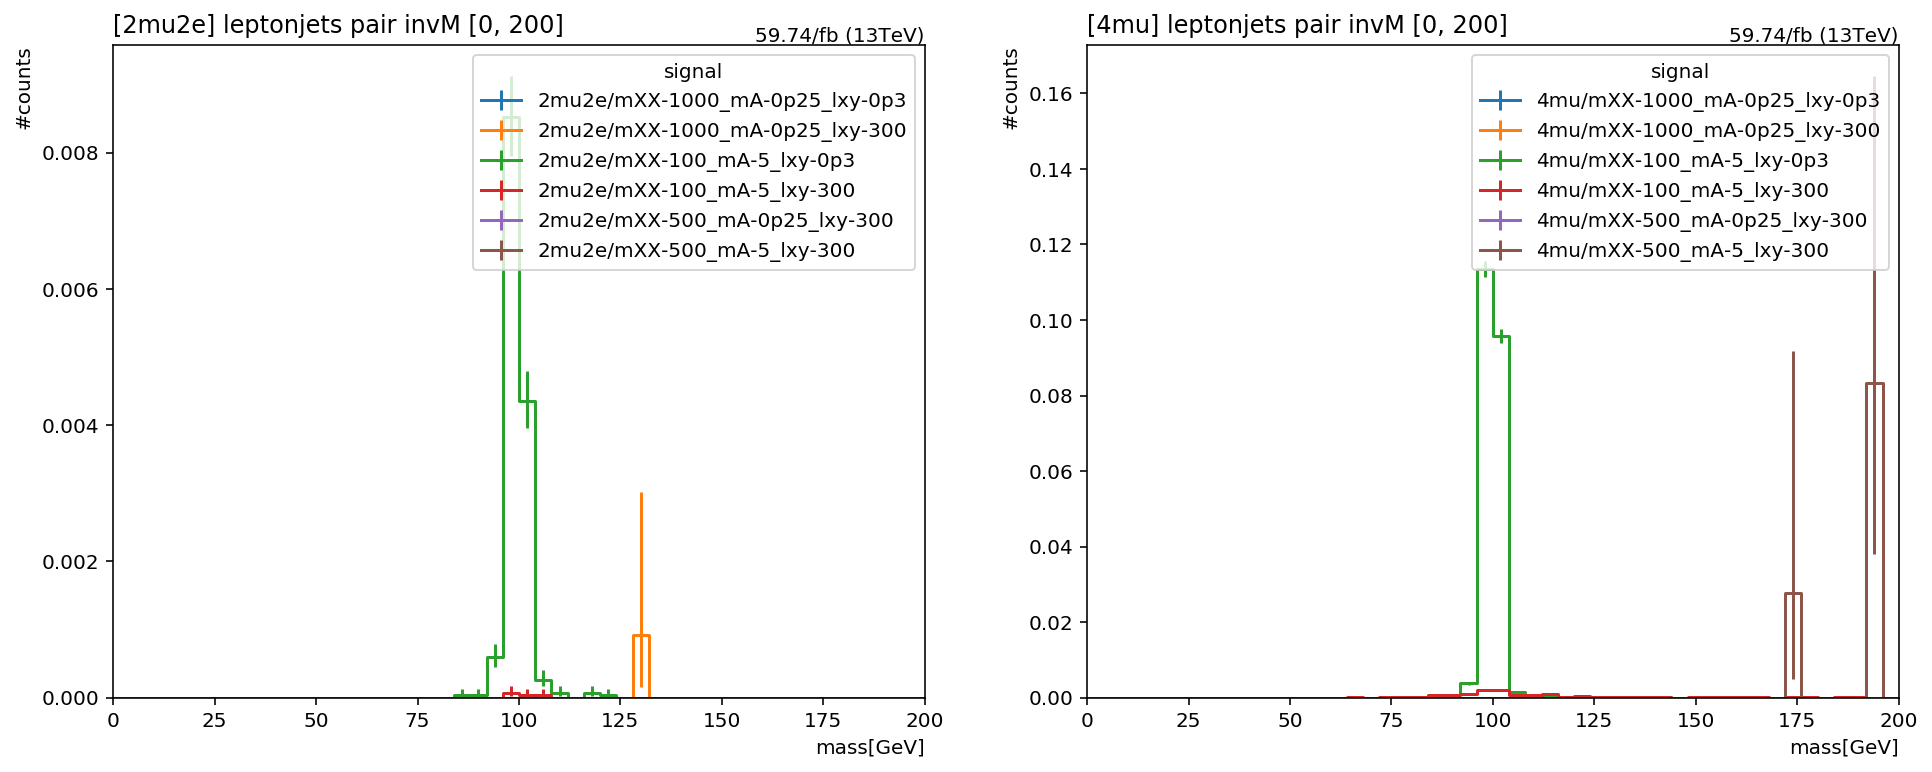

In [16]:
makeplotsignal('ljpair-invm1', 'pair invM [0, 200]', overflow='over', logy=False,)

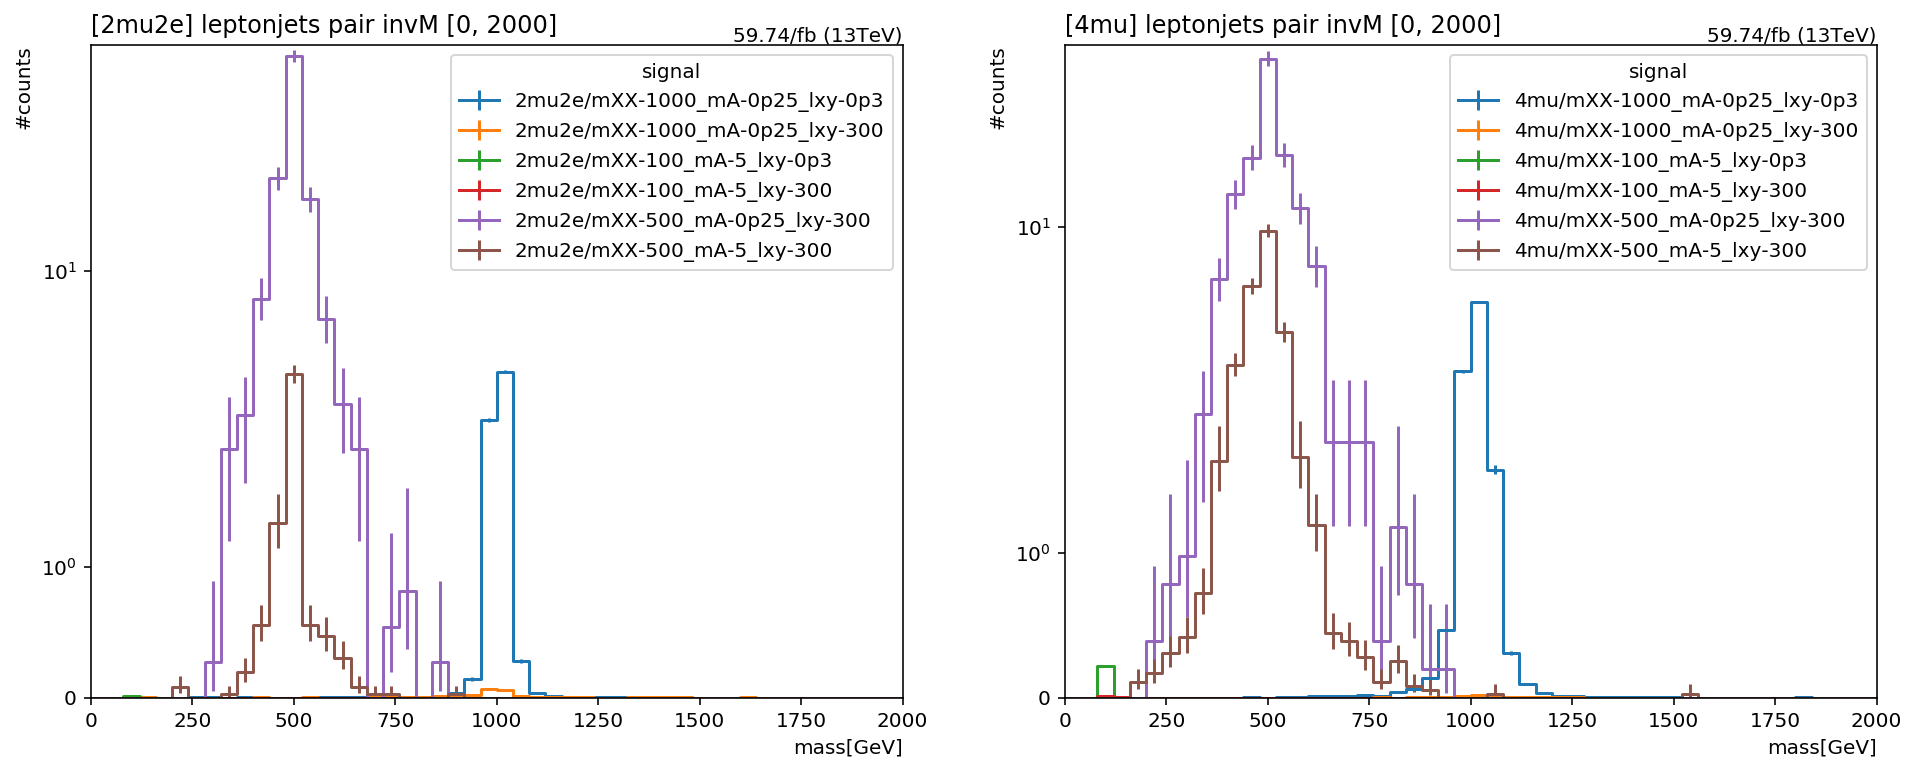

In [17]:
makeplotsignal('ljpair-invm2', 'pair invM [0, 2000]', overflow='over', logy=True,)

---

In [35]:
from collections import defaultdict

def makeplotcomb(varname, title, overflow='none', logy=True, ylim=None):
    fig, axes=plt.subplots(1,2,figsize=(16,6))
    hist.plot1d(output[varname+'_cat'].integrate('channel', slice(1,2)), overlay='cat', ax=axes[0],
               clear=False, stack=True, overflow=overflow,
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(output[varname+'_cat'].integrate('channel', slice(2,3)), overlay='cat', ax=axes[1],
               clear=False, stack=True, overflow=overflow,
               line_opts=None, fill_opts=fill_opts, error_opts=error_opts)
    hist.plot1d(sigoutput['2mu2e'][varname].integrate('channel', slice(1,2)), overlay='dataset', ax=axes[0],
                clear=False, overflow=overflow)
    hist.plot1d(sigoutput['4mu'][varname].integrate('channel', slice(2,3)), overlay='dataset', ax=axes[1],
                clear=False, overflow=overflow)
    for ax in axes:
        ax.autoscale(axis='x', tight=True)
        if logy:
            ax.set_yscale('log')
            ax.set_ylim([1e-2, 2e2])
            ax.autoscale(axis='y', tight=True)
        if ylim:
            ax.set_ylim(*ylim)
        ax.set_xlabel(ax.get_xlabel(), x=1.0, ha="right")
        leg=ax.legend()
        hl_ = defaultdict(list)
        for h, l in zip(*ax.get_legend_handles_labels()):
            hl_[l].append(h)
        l2 = hl_.keys()
        h2 = list()
        for h_ in hl_.values():
            h2.append(tuple(h_))
        ax.legend(h2, l2, prop={'size': 8})
        ax.set_ylabel(ax.get_ylabel(), y=1.0, ha="right")
        ax.text(1,1,'59.74/fb (13TeV)',
                ha='right', va='bottom', transform=ax.transAxes)

    axes[0].set_title(f'[2mu2e] leptonjets {title}', x=0.0, ha="left")
    axes[1].set_title(f'[4mu] leptonjets {title}', x=0.0, ha="left")

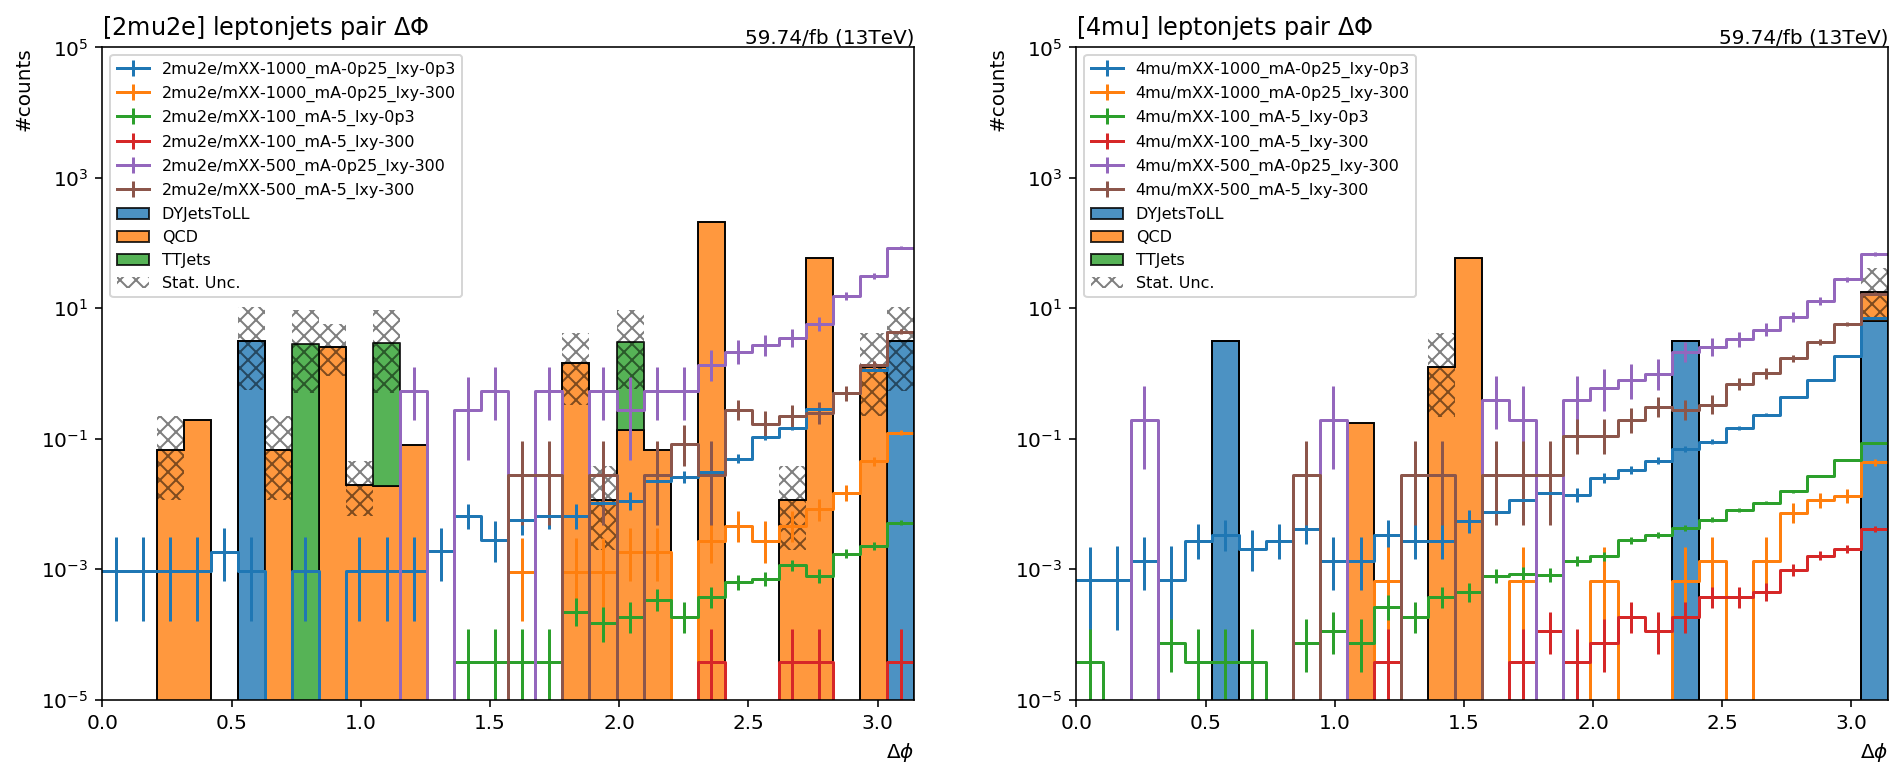

In [37]:
makeplotcomb('ljpair-dphi', 'pair $\Delta\Phi$', overflow='none', logy=True, ylim=[1e-5, 1e5])

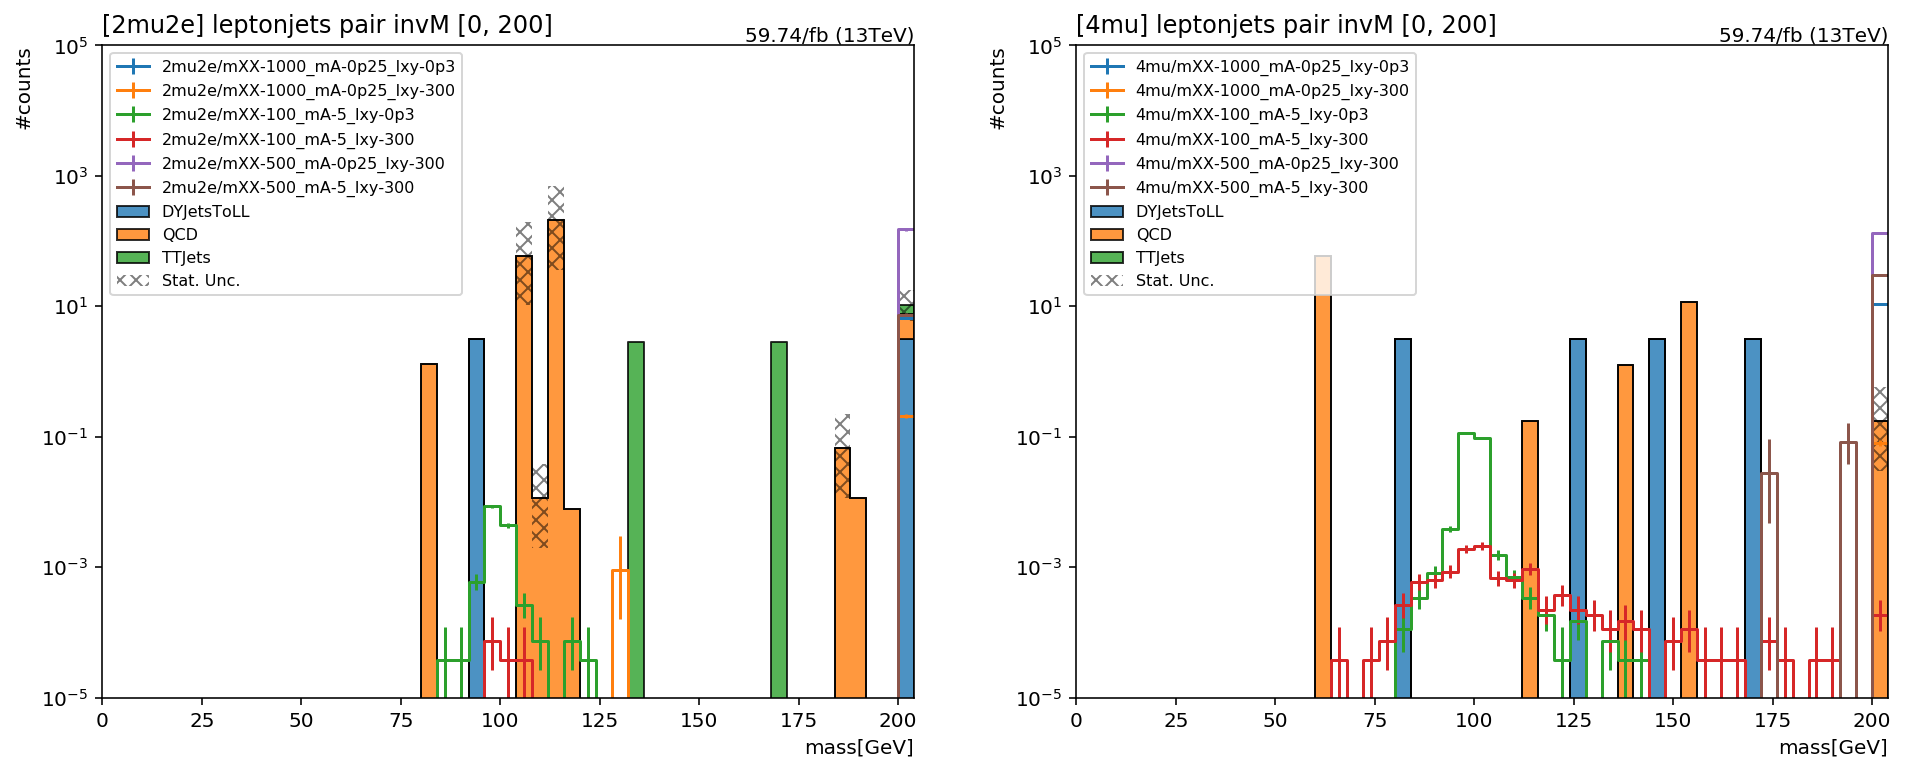

In [38]:
makeplotcomb('ljpair-invm1', 'pair invM [0, 200]', overflow='over', logy=True, ylim=[1e-5, 1e5])

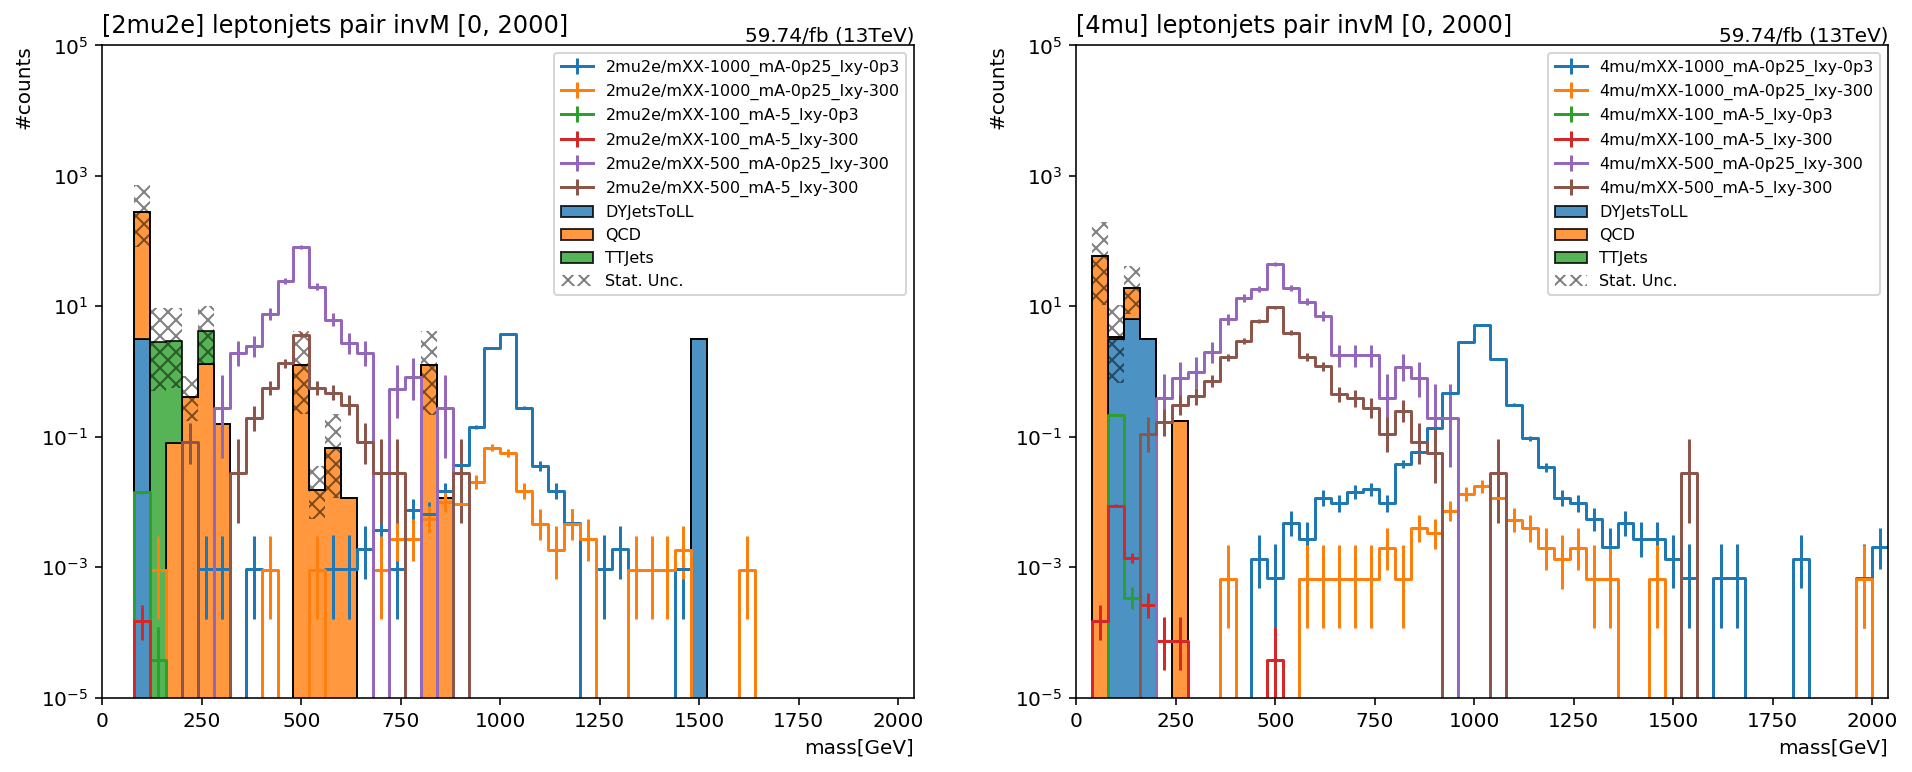

In [39]:
makeplotcomb('ljpair-invm2', 'pair invM [0, 2000]', overflow='over', logy=True, ylim=[1e-5, 1e5])